<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> EDO - Aplicaciones Avanzadas </h2>
    <h2> [[S]cientific [C]omputing [T]eam](#acknowledgements)</h2>
    <h2> Version: 1.1</h2>
</center>

## Algunos algoritmos utilizados en este notebook han sido obtenidos del libro "Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000" y traducidos a python.

# Tabla de Contenidos
* [Introducción](#intro)
* [Configuraciones](#config)
* [Problemas de Valor Inicial](#IVP)
    * [Algunos Solver Típicos](#solver)
        * [Regiones de Estabilidad](#stab)
        * [Convergencia](#conver)
    * [Problemas de segundo orden y más dimensiones](#high)
* [Problemas de Valor de Frontera](#BVP)
    * [Diferencias Finitas](#DD)
    * [Método de Disparo](#MD)
* [Acknowledgements](#acknowledgements)

<div id='intro' />
# Introducción
En este notebook estudiaremos métodos numéricos para la resolución de ecuaciones diferenciales ordinarias (EDO). Se verán problemas de valor inicial (IVP) y de valor de frontera (BVP), sus principales métodos de resolución y se analizarán estabilidad y convergencia para los primeros mencionados.

# Configuration

In [1]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
import numpy as np
from scipy.integrate import odeint
from pylab import *
from numpy import linalg as LA
from matplotlib.legend_handler import HandlerLine2D
from scipy.linalg import toeplitz
from scipy.optimize import root

# Global parameter that controls the figure's size
L = 10

# Definitions

In [2]:
# Forward Euler Method
def euler_ode(y,t,f,h):
    return y+h*f(t,y)

# Runge-Kutta of Second order
def RK2_ode(y,t,f,h):
    k1=y+h/2.0*f(t,y) #or euler_ode(y,t,f,h)
    return y+h*f(t+h/2.0,k1)

# Runge-Kutta of Fourth order
def RK4_ode(y,t,f,h):
    k1=f(t,y)
    k2=f(t+h/2.0,y+(h/2.0)*k1)
    k3=f(t+h/2.0,y+(h/2.0)*k2)
    k4=f(t+h,y+h*k3)
    return y+(h/6.0)*(k1+2.0*k2+2.0*k3+k4)

# Adams-Bashforth of Second order
def AB2_ode(y,t,f,h,y_prev):
    return y+(h/2.0)*(3*f(t,y)-f(t-h,y_prev))

# Adams-Bashforth-Moulton of Second order
def ABM2_ode(y,t,f,h,y_prev):
    y_pred=AB2_ode(y,t,f,h,y_prev)
    return y+(h/2.0)*(f(t+h,y_pred)+f(t,y))

# Adams-Bashforth of Fourth order
def AB4_ode(y,t,f,h,y_m1,y_m2,y_m3):
    return y+(h/24.0)*(55*f(t,y)-59*f(t-h,y_m1)+37*f(t-2*h,y_m2)-9*f(t-3*h,y_m3))

# Adams-Bashforth-Moulton of Fourth order
def ABM4_ode(y,t,f,h,y_m1,y_m2,y_m3):
    y_pred=AB4_ode(y,t,f,h,y_m1,y_m2,y_m3)
    return y+(h/24.0)*(9*f(t+h,y_pred)+19*f(t,y)-5*f(t-h,y_m1)+f(t-2*h,y_m2))

# Evaluation

In [3]:
# y0=3.0
# time_test=0.5
def my_f(t,y):
    return np.array(-3*y+6*t+5)
y_sol = lambda t: 2.*np.exp(-3.*t)+2.*t+1

In [8]:
m = 0
M = 4
h = 0.1

# Arrays for testing
tl = np.arange(m, M, h)
yl = np.zeros(tl.size)
yl[0:4] = y_sol(tl[0:4])

# Testing
y_real  = y_sol(tl)
y_euler = np.copy(yl)
y_rk2   = np.copy(yl)
y_rk4   = np.copy(yl)
y_ab2   = np.copy(yl)
y_abm2  = np.copy(yl)
y_ab4   = np.copy(yl)
y_abm4  = np.copy(yl)
for i in range(4, len(tl)):
    y_euler[i] = euler_ode(y_euler[i-1], tl[i-1], my_f, h)
    y_rk2[i] = RK2_ode(y_rk2[i-1], tl[i-1], my_f, h)
    y_rk4[i] = RK4_ode(y_rk4[i-1], tl[i-1], my_f, h)    
    y_ab2[i] = AB2_ode(y_ab2[i-1], tl[i-1], my_f, h, y_ab2[i-2])
    y_abm2[i] = ABM2_ode(y_abm2[i-1], tl[i-1], my_f, h, y_abm2[i-2])
    y_ab4[i] = AB4_ode(y_ab4[i-1], tl[i-1], my_f, h, y_ab4[i-2], y_ab4[i-3], y_ab4[i-4])
    y_abm4[i] = ABM4_ode(y_abm4[i-1], tl[i-1], my_f, h, y_abm4[i-2], y_abm4[i-3], y_abm4[i-4])

# Convergence Order

In [31]:
m = 0
M = 10
h_list = np.logspace(-5,0,6)
e_list = []
for h in h_list:
    e_list.append([])
    tl = np.arange(m, M, h)
    yl = np.zeros(tl.size)
    yl[0:4] = y_sol(tl[0:4])

    y_real  = y_sol(tl)
    y_euler = np.copy(yl)
    y_rk2   = np.copy(yl)
    y_rk4   = np.copy(yl)
    y_ab2   = np.copy(yl)
    y_abm2  = np.copy(yl)
    y_ab4   = np.copy(yl)
    y_abm4  = np.copy(yl)
    for i in range(7):
        e_list[-1].append(0)
    
    for i in range(4, len(tl)):
        y_euler[i] = euler_ode(y_euler[i-1], tl[i-1], my_f, h)
        e_list[-1][0] += np.abs(y_euler[i] - y_real[i])

        y_rk2[i] = RK2_ode(y_rk2[i-1], tl[i-1], my_f, h)
        e_list[-1][1] += np.abs(y_rk2[i] - y_real[i])
        
        y_rk4[i] = RK4_ode(y_rk4[i-1], tl[i-1], my_f, h)    
        e_list[-1][2] += np.abs(y_rk4[i] - y_real[i])
        
        y_ab2[i] = AB2_ode(y_ab2[i-1], tl[i-1], my_f, h, y_ab2[i-2])
        e_list[-1][3] += np.abs(y_ab2[i] - y_real[i])
        
        y_abm2[i] = ABM2_ode(y_abm2[i-1], tl[i-1], my_f, h, y_abm2[i-2])
        e_list[-1][4] += np.abs(y_abm2[i] - y_real[i])
        
        y_ab4[i] = AB4_ode(y_ab4[i-1], tl[i-1], my_f, h, y_ab4[i-2], y_ab4[i-3], y_ab4[i-4])
        e_list[-1][5] += np.abs(y_ab4[i] - y_real[i])
        
        y_abm4[i] = ABM4_ode(y_abm4[i-1], tl[i-1], my_f, h, y_abm4[i-2], y_abm4[i-3], y_abm4[i-4])
        e_list[-1][6] += np.abs(y_abm4[i] - y_real[i])
    
    for i in range(7):
        e_list[-1][i]/(len(tl)-4)

In [54]:
# Scatter plots arrays of equal size
def scatter_plot(h, arrs, names):
    fig, ax = plt.subplots()
    
    fig.set_size_inches((L,L))

    for i in range(len(arrs)):
        plt.scatter(h, arrs[i], label=names[i])
        plt.plot(   h, arrs[i])

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("h")
    plt.ylabel("error")
    plt.legend()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linestyle='-', linewidth=0.25, alpha=0.5)

    plt.tight_layout()
    plt.show()
    return

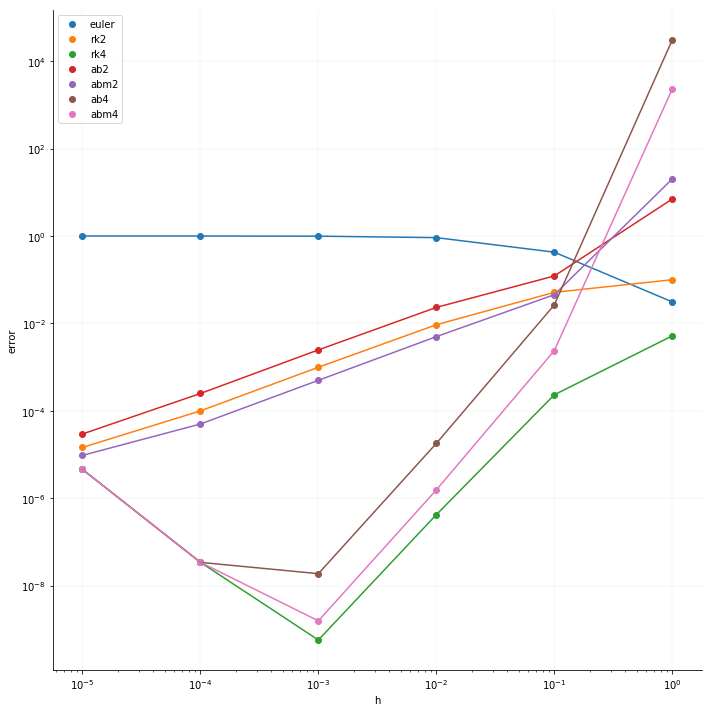

In [55]:
names = ["euler", "rk2", "rk4", "ab2", "abm2", "ab4", "abm4"]
scatter_plot(h_list, np.array(e_list).transpose(), names)

NameError: name 'time_test' is not defined

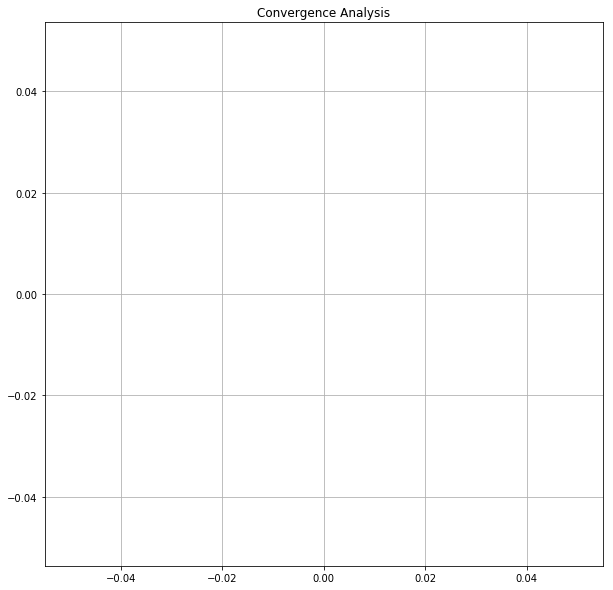

In [10]:
fig = pyplot.figure(figsize=(L,L))
fig.clf()
ax = fig.gca()
ax.axis("equal")
ax.grid(True)
ax.set_title("Convergence Analysis")

h_list = np.logspace(-5,-1,5)
for h in h_list:
    t_times = np.arange(0, time_test+h, h)

    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f,h)        
    loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'b.',ms=20,label='Euler',alpha=.5)
    
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f,h)
    loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'rs',ms=20,label='RK2',alpha=.5)
    
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f,h)
    loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'gd',ms=20,label='RK4',alpha=.5)
    
    if h==h_list[0]:
        plt.legend(numpoints=1, loc="lower right")
loglog(h_list,h_list,'k-')
loglog(h_list,np.power(h_list,2.),'k-')
loglog(h_list,np.power(h_list,4.),'k-')

### Ejemplo en 1-D

Resolviendo $\dot{y}(t) = y(t)(1-y(t))$ para distintas condiciones iniciales $y_0$, tenemos:

In [ ]:
# Logistic Equation
def my_f_1D(t,y):
    return np.array(y*(1-y))

In [ ]:
h=0.001
t_times = np.arange(0, 4, h)
fig = pyplot.figure(figsize=(L,L))
fig.clf()
ax = fig.gca()
ax.axis("equal")
ax.grid(True)
ax.set_title("Numerical Approximations and Direction Field")
ax.axis([0, 4, -2, 2])

for y0 in np.arange(-1,5,0.1): 
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        #y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
        #y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
    plot(t_times,y_output,'-')

X,Y = meshgrid( np.arange(0,4,.2),arange(-2,2,.2) )
theta = np.arctan(my_f_1D(0,Y))
U = cos(theta)
V = sin(theta)
quiver(X,Y,U,V)

<div id='stab' />
## Regiones de Estabilidad

Para analizar la estabilidad lineal de un método consideremos la ecuación diferencial $\dot{y} = \lambda y$, con $y(0)=1$, cuya solución es $y(t) = e^{\lambda t}$.

Para Euler tendríamos:

\begin{align*}
    y_{i+1} &= y_i + \lambda h y_i \\
    y_{i+1} &= (1 + \lambda h ) y_i \\
    y_{i+1} &= (1 + \lambda h )^{i+1} y_0 
\end{align*}

Considerando la parte real de $\lambda$ negativa y $h$ positivo, para recrear la solución se necesita que $\left|1+\lambda h \right| <1$. Este dominio, se denomina la región de estabilidad del método. 

Del mismo modo, para los demás métodos tenemos:

* RK2:
$$ \left|1+\lambda h + \dfrac{(\lambda h)^2}{2!} \right| <1 $$

* RK4:
$$ \left| 1+\lambda h + \dfrac{(\lambda h)^2}{2!} + \dfrac{(\lambda h)^3}{3!} + \dfrac{(\lambda h)^4}{4!} \right| <1 $$

In [ ]:
def zplot2(z, ax=pyplot.gca(), lw=1.5, line_color='k'):
  ax.plot(np.real(z), np.imag(z), line_color, lw=lw)
def runge_kutta_stability_regions():
  z = np.exp(1j * np.pi * np.arange(201)/100.)
  r = z-1
  d = 1-1./z;
  # Order 1
  W1, W2, W3, W4 = [0], [0], [0], [0]
  for zi in z[1:]:
    W1.append( W1[-1]-(1.+W1[-1]-zi) )
  for zi in z[1:]:
    W2.append( W2[-1]-(1+W2[-1]+.5*W2[-1]**2-zi**2)/(1+W2[-1]) )
  for zi in z[1:]:
    num = (1+W4[-1]+.5*W4[-1]**2+W4[-1]**3/6+W4[-1]**4/24-zi**4)
    den = (1+W4[-1]+W4[-1]**2/2+W4[-1]**3/6.)
    W4.append( W4[-1] - num/den )
  return W1, W2, W4
W1,W2,W4=runge_kutta_stability_regions()

In [ ]:
fig = pyplot.figure(figsize=(L,L))
ax=fig.gca()
zplot2(W1,ax,line_color='r')
zplot2(W2,ax,line_color='g')
zplot2(W4,ax,line_color='b')
ax.axis("equal")
ax.axis([-5, 2, -3.5, 3.5])
ax.grid("on")
ax.set_title("Stability Regions of some Runge-Kutta ODE solvers")

### Entonces, ¿cómo utilizamos la región de estabilidad?

Lo importante de este análisis es notar que no podemos definir $h$ a priori. Dados un método y $\lambda$ conocidos, debemos estudiar la región de estabilidad para determinar que valor de $h$ utilizar.

In [ ]:
y0=1.2 # 1.2, 2.0, 4.0
h=0.5  # 0.5, 0.1
T=10

# How did I get this? Why do I need it?
def my_f_1D_prime(y):
    return np.array(1-2*y)

# Choosing which solver to use
solvers = ('euler','RK2','RK4')
solver = solvers[2]

t_times = np.arange(0, T+h, h)
y_output = np.zeros(t_times.size)
y_output[0] = y0

for i in range(1,t_times.size):
    if solver=='euler':
        y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
        c1,c2,c3='b','k','k'
    elif solver=='RK2':
        y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
        c1,c2,c3='k','b','k'
    else:
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f_1D,h)
        c1,c2,c3='k','k','b'

fig = pyplot.figure(figsize=(L,L/2))
ax = fig.gca()
ax.axis("equal")
ax.grid(True)
ax.set_title("Numerical Approximation")
ax.axis([0, T, -0.5, 2])
plot(t_times,y_output,'-')
plot(t_times,y_output,'.k')

fig = pyplot.figure(figsize=(L,L))
ax=fig.gca()
zplot2(W1,ax,line_color=c1)
zplot2(W2,ax,line_color=c2)
zplot2(W4,ax,line_color=c3)
k_lambdah=h*my_f_1D_prime(y_output)
plot(np.real(k_lambdah),np.imag(k_lambdah),'.r',ms=20)
ax.axis("equal")
ax.axis([-5, 2, -3.5, 3.5])
ax.grid("on")
ax.set_title("Stability Region and $k=\lambda\,h$")

# The next code is to plot in logscale unstable numerical simulations
fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
y_all=h*my_f_1D_prime(y_output)
y_pos=y_all>0
y_neg=logical_not(y_pos)
semilogy(t_times[y_pos],y_all[y_pos],'.r',ms=20)
semilogy(t_times[y_neg],-y_all[y_neg],'.b',ms=20)
#ax.axis([-5, 2, -3.5, 3.5])
ax.grid("on")
ax.set_title("Stability Region and $k=\lambda\,h$")

<div id='conver' />
## Convergencia

¡Esto es muy importante! Estudiémoslo... 

Para hablar de convergencia, tenemos que tener en cuenta el orden de cada método. En palabras simples y resumidas podemos decir lo siguiente:

* Euler es un método de primer orden $O(h)$, por lo que si $h$ se reduce a la mitad, el error también lo hace.
* RK2 es un método de segundo orden $O(h^2)$, por lo que si $h$ se reduce a la mitad, el error se reduce a la cuarta parte.
* RK4 es un método de cuarto orden $O(h^4)$, por lo que si $h$ se reduce a la mitad, el error se reduce 16 veces.

Para ver esto, consideremos el siguiente problema:

\begin{align*}
\dot{y}(t)&=-3\,y(t)+6\,t+5\\
y(0)&=3
\end{align*}

cuya solución es $y(t)=2e^{-3t}+2t+1$.

In [ ]:
y0=3.0
time_test=0.5
def my_f(t,y):
    return np.array(-3*y+6*t+5)
y_sol = lambda t: 2.*np.exp(-3.*t)+2.*t+1

In [ ]:
fig = pyplot.figure(figsize=(L,L))
fig.clf()
ax = fig.gca()
ax.axis("equal")
ax.grid(True)
ax.set_title("Convergence Analysis")

h_list = np.logspace(-5,-1,5)
for h in h_list:
    t_times = np.arange(0, time_test+h, h)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=euler_ode(y_output[i-1],t_times[i-1],my_f,h)        
    loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'b.',ms=20,label='Euler',alpha=.5)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK2_ode(y_output[i-1],t_times[i-1],my_f,h)
    loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'rs',ms=20,label='RK2',alpha=.5)
    y_output = np.zeros(t_times.size)
    y_output[0] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],my_f,h)
    loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'gd',ms=20,label='RK4',alpha=.5)
    if h==h_list[0]:
        plt.legend(numpoints=1, loc="lower right")
loglog(h_list,h_list,'k-')
loglog(h_list,np.power(h_list,2.),'k-')
loglog(h_list,np.power(h_list,4.),'k-')

<div id='high' />
# Problemas de segundo orden y más dimensiones

¿Por qué debemos estudiar problemas de dimensiones más altas?

¡Porque son geniales!

### Van der pool

El ocsilador Van der Pol es un oscilador no conservativo con amortiguamiento no lineal. Su evolución en el tiempo sigue una ecuación diferencial de segundo orden: 

$$\ddot{y}-\mu (1-y^2) \dot{y} + y = 0$$ con $y(0)=2\ $   y   $\dot{y}(0)=0$

$\mu$ es un parámetro escalar que indica la no linealidad y la fuerza del amortiguamiento.

$y_1(t)=y(t)$ <br>
$y_2(t)=\dot{y}(t)$ <br> 
$\dot{y}_1=\dot{y} = y_2$ <br>
$\dot{y}_2=\ddot{y} = \mu (1-y^2) \dot{y} - y = \mu (1-y_1^2) y_2 - y_1$ <br> 

In [ ]:
mu=10
def my_vdp(t,y):
    y1 = y[0]
    y2 = y[1]
    return np.array([y2, mu*(1-y1**2)*y2-y1])

def my_vdp_eig_jacobian(t,y):
    J=[[0,1],[-(2*mu*y[0]*y[1]+1), mu*(1-y[0]**2)]]
    lambs,vs= LA.eig(J)
    return lambs

In [ ]:
y0=[2, 0]

h=0.01

T=200

t_times = np.arange(0, T, h)
y_output = np.zeros([t_times.size,2])
y_output[0,:] = y0
for i in range(1,t_times.size):
    y_output[i,:]=euler_ode(y_output[i-1,:],t_times[i-1],my_vdp,h)
    
fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Numerical Approximation")
plot(t_times,y_output[:,0],'-')

fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Phase Portrait")
plot(y_output[:,0],y_output[:,1],'-')
plt.xlabel('$y=y_1$',fontsize=24);
plt.ylabel('$\dot{y}=y_2$',fontsize=24);

### ¿Qué hay acerca de la región de estabilidad en sistemas dinámicos de EDO's?

In [ ]:
y0=[2, 0]
h=0.02
T=40

# Choosing which solver to use
solvers = ('euler','RK2','RK4')
solver = solvers[0]

t_times = np.arange(0, T+h, h)
y_output = np.zeros([2,t_times.size])
y_output[:,0] = y0

for i in range(1,t_times.size):
    if solver=='euler':
        y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],my_vdp,h)
        c1='b'
        c2='k'
        c3='k'
    elif solver=='RK2':
        y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],my_vdp,h)
        c1='k'
        c2='b'
        c3='k'
    else:
        y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],my_vdp,h)
        c1='k'
        c2='k'
        c3='b'

In [ ]:
fig = pyplot.figure(figsize=(L,L/2))
ax = fig.gca()
ax.axis("equal")
ax.grid(True)
ax.set_title("Numerical Approximation")
ax.axis([0, T, -0.5, 2])
plot(t_times,y_output[0,:],'-')
plot(t_times,y_output[1,:],'r-')

fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Phase Portrait")
plot(y_output[0,:],y_output[1,:],'-')
plt.xlabel('$y=y_1$',fontsize=24);
plt.ylabel('$\dot{y}=y_2$',fontsize=24);

fig = pyplot.figure(figsize=(L,L))
ax=fig.gca()
zplot2(W1,ax,line_color=c1)
zplot2(W2,ax,line_color=c2)
zplot2(W4,ax,line_color=c3)
for i in range(1,t_times.size):
    k_lambdah=h*my_vdp_eig_jacobian(t_times[i],y_output[:,i])
    plot(np.real(k_lambdah[0]),np.imag(k_lambdah[0]),'.r',ms=10,alpha=.4)
    plot(np.real(k_lambdah[1]),np.imag(k_lambdah[1]),'sm',ms=10,alpha=.4)
ax.axis("equal")
ax.axis([-5, 2, -3.5, 3.5])
ax.grid("on")

### Modelo Lotka-Volterra (ecuaciones predador-presa), es decir, lobos comiendo conejos y conejos escondiendo y comiendo pasto infinito.

Se definen $y1(t)$ como el número de conejos en el tiempo $t$ y $y2(t)$ como el número de lobos en el tiempo $t$. Todo esto está pasando en una isla, aunque estamos considerando la presencia de pasto infinito. Entonces, si no hay lobos, obtenemos $\dot{y1}(t)=y1(t)$, en otras palabras, el número de conejos crece exponencialmente. Ahora, si no hubiesen conejos, obtenemos $\dot{y2}(t)=-y2(t)$, debido a que la población de lobos decae exponencialmente. Pero, ¿qué pasa si tenemos ambas especies?

\begin{align*}
\dot{y1}(t)&=(1-y2(t)/\mu_2)\,y1(t)\\
\dot{y2}(t)&=-(1-y1(t)/\mu_1)\,y2(t)\\
y1(0)&=400\\
y2(0)&=100
\end{align*}

donde $\mu_1$ y $\mu_2$ son constantes de normalización.

In [ ]:
LA.eig(np.array([[-2, 2,0],[1,-1,-1],[0,0,0]]))

In [ ]:
mu1=300
mu2=200
def f_predprey(t,y):
    y1 = y[0]
    y2 = y[1]
    return np.array([(1-y2/mu2)*y1, -(1-y1/mu1)*y2])

def f_predprey_jacobian(t,y):
    J=[[1-y[1]/mu2,-y[0]/mu2],[y[1]/mu1, -(1-y[0]/mu1)]]
    lambs,vs= LA.eig(J)
    return lambs

In [ ]:
y0=[400, 100]
h=0.03
T=30

# Choosing which solver to use
solvers = ('euler','RK2','RK4')
solver = solvers[2]

t_times = np.arange(0, T+h, h)
y_output = np.zeros([2,t_times.size])
y_output[:,0] = y0

for i in range(1,t_times.size):
    if solver=='euler':
        y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],f_predprey,h)
        c1='b'
        c2='k'
        c3='k'
    elif solver=='RK2':
        y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],f_predprey,h)
        c1='k'
        c2='b'
        c3='k'
    else:
        y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],f_predprey,h)
        c1='k'
        c2='k'
        c3='b'

In [ ]:
fig = pyplot.figure(figsize=(L,L/2))
ax = fig.gca()
ax.grid(True)
ax.set_title("Numerical Approximation")
plot(t_times,y_output[0,:],'-')
plot(t_times,y_output[1,:],'r-')
ax.axis([0, T, 0, 600])

fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Phase Portrait")
plot(y_output[0,:],y_output[1,:],'-')
plt.xlabel('$y1$',fontsize=24);
plt.ylabel('$y2$',fontsize=24);
ax.axis([0, 800, 0, 600])

fig = pyplot.figure(figsize=(L,L))
ax=fig.gca()
zplot2(W1,ax,line_color=c1)
zplot2(W2,ax,line_color=c2)
zplot2(W4,ax,line_color=c3)
for i in range(1,t_times.size):
    k_lambdah=h*my_vdp_eig_jacobian(t_times[i],y_output[:,i])
    plot(np.real(k_lambdah[0]),np.imag(k_lambdah[0]),'.r',ms=10,alpha=.4)
    plot(np.real(k_lambdah[1]),np.imag(k_lambdah[1]),'sm',ms=10,alpha=.4)
ax.axis("equal")
ax.axis([-5, 2, -3.5, 3.5])
ax.grid("on")

In [ ]:
def f_inclass(t,y):
    y1 = y[0]
    y2 = y[1]
    return np.array([y2, -y1])

y0=[1, 0]
h=0.03
T=100

# Choosing which solver to use
solvers = ('euler','RK2','RK4')
solver = solvers[0]

t_times = np.arange(0, T+h, h)
y_output = np.zeros([2,t_times.size])
y_output[:,0] = y0

for i in range(1,t_times.size):
    if solver=='euler':
        y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],f_inclass,h)
        c1='b'
        c2='k'
        c3='k'
    elif solver=='RK2':
        y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],f_inclass,h)
        c1='k'
        c2='b'
        c3='k'
    else:
        y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],f_inclass,h)
        c1='k'
        c2='k'
        c3='b'
fig = pyplot.figure(figsize=(L,L/2))
ax = fig.gca()
ax.grid(True)
ax.set_title("Numerical Approximation")
plot(t_times,y_output[0,:],'-')
plot(t_times,y_output[1,:],'r-')
ax.axis([0, T, -2, 2])

fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Phase Portrait")
plot(y_output[0,:],y_output[1,:],'-')
plt.xlabel('$y1$',fontsize=24);
plt.ylabel('$y2$',fontsize=24);
ax.axis([-2, 2, -2, 2])
ax.axis("equal")
ax.grid("on")

In [ ]:
def f_inclass(t,y):
    y1 = y[0]
    return np.array([-y1])

y0=[1, 0]
h=0.1
T=10

# Choosing which solver to use
solvers = ('euler','RK2','RK4')
solver = solvers[0]

t_times = np.arange(0, T+h, h)
y_output = np.zeros([2,t_times.size])
y_output[:,0] = y0

for i in range(1,t_times.size):
    if solver=='euler':
        y_output[:,i]=euler_ode(y_output[:,i-1],t_times[i-1],f_inclass,h)
        c1='b'
        c2='k'
        c3='k'
    elif solver=='RK2':
        y_output[:,i]=RK2_ode(y_output[:,i-1],t_times[i-1],f_inclass,h)
        c1='k'
        c2='b'
        c3='k'
    else:
        y_output[:,i]=RK4_ode(y_output[:,i-1],t_times[i-1],f_inclass,h)
        c1='k'
        c2='k'
        c3='b'
fig = pyplot.figure(figsize=(L,L/2))
ax = fig.gca()
ax.grid(True)
ax.set_title("Numerical Approximation")
plot(t_times,y_output[0,:],'-')
ax.axis([0, T, -2, 2])
ax.axis("equal")
ax.grid("on")

<div id='BVP' />
# Problemas de Valor de Frontera

Un problema de valor de frontera (BVP) corresponde a una ecuación diferencial ordinaria de la forma:

$$ y''(x) = f(x,y(x),y'(x)) $$
sujeta a condiciones de borde:

$$ y(a) = y_a $$
$$ y(b) = y_b $$

Intentemos resolver $y''(x)=4y(x)$, con $y(0)=\alpha$ y $y(1)=\beta$.

<div id='DD' />
## Diferencias Finitas

Este método consiste en aproximar las derivadas de $y(x)$ mediante las denominadas diferencias finitas, para luego resolver un sistema de ecuaciones que encuentre la solución.

Dentro de las más conocidas están:

* Central Difference:
$$ y'(x) = \dfrac{y(x+h) - y(x-h)}{2h} + O(h^2)$$

* Forward Difference:
$$ y'(x) = \dfrac{y(x+h) - y(x)}{h} + O(h)$$

* Backward Difference:
$$ y'(x) = \dfrac{y(x) - y(x-h)}{h} + O(h)$$

Y para aproximar la segunda derivada utilizamos:
\begin{align*}
y''(x) &= \dfrac{\text{Forward Difference } - \text{ Backward Difference}}{h} + O(h^2) \\
y''(x) &= \dfrac{\dfrac{y(x+h) - y(x)}{h} - \dfrac{y(x) - y(x-h)}{h}}{h} + O(h^2) \\
y''(x) &= \dfrac{y(x+h) - 2y(x) + y(x-h)}{h^2} + O(h^2) \\
\end{align*}

In [ ]:
I=4
h=1./I
alpha=1.
beta=3.
delta=-(2.+4.*(h**2.))
A=toeplitz(np.append(np.array([delta, 1.]), np.zeros(I-3)))
b=np.append(-alpha, np.zeros(I-3))
b=np.append(b,-beta)
w=np.linalg.solve(A, b)
w=np.append([alpha], w)
w=np.append(w,[beta])

fig = pyplot.figure(figsize=(L,L))
fig.clf()
ax = fig.gca()
ax.grid(True)
ax.set_title("FD")
t_FD = np.linspace(0,1,I+1)
w_FD = w 
plot(t_FD,w_FD,'.',ms=20)
ax.axis([0, 1, 0, 3])
ax.grid("on")

<div id='MD' />
## Método de Disparo

Este método consiste en tratar el BVP como si fuera un IVP mediante las siguientes consideraciones:

* Teniendo el BVP $ y''(x) = f(x,y(x),y'(x)) $,con $ y(a) = y_a $ y $ y(b) = y_b $.
* Consideremos $x \rightarrow t$ y $ \ddot{y}(t) = f(x,y(x),\dot{y}(x)) $,con $ y(t_0) = y_0 $ y $ \dot{y}(t_0) = \alpha $.
* Y definamos la función $F(\alpha) = y(t_n;\alpha) - y_b$.

Entonces solo basta con encontrar una raíz de $F(\alpha)$ para que la solución de este IVP corresponda a la solución del BVP que en realidad estamos resolviendo.

In [ ]:
def my_f(t,y):
    return np.array([y[1],4*y[0]])

In [ ]:
alpha=-1.;

y0=1
T=1.0
N=100
h=T/(N-1.)

t_times = np.linspace(0,T,num=N)
y_output = np.zeros([t_times.size,2])
y_output[0,:] = [y0,alpha]
for i in range(1,t_times.size):
    y_output[i,:]=euler_ode(y_output[i-1,:],t_times[i-1],my_f,h)
fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Numerical Approximation")
plot(t_times,y_output[:,0],'rd',ms=12,alpha=0.5)
plot(t_FD,w_FD,'.',ms=20,alpha=0.5)

### Ahora hagámoslo automáticamente

In [ ]:
N_grid = 100
def func(alpha):
    beta=3
    t_times,y_output = my_solver(N_grid,alpha)
    return y_output[-1,0]-beta

def my_solver(N,alpha):
    y0=1.
    T=1.0
    h=T/(N-1.)
    t_times = np.linspace(0,T,num=N)
    y_output = np.zeros([t_times.size,2])
    y_output[0,:] = [y0,alpha]
    for i in range(1,t_times.size):
        y_output[i,:]=RK4_ode(y_output[i-1,:],t_times[i-1],my_f,h)
    return (t_times,y_output)

In [ ]:
alpha = root(func, 0.)
t_times,y_output = my_solver(N_grid,alpha.x)
fig = pyplot.figure(figsize=(L,L))
ax = fig.gca()
ax.grid(True)
ax.set_title("Numerical Approximation")
plot(t_times,y_output[:,0],'rd',ms=20,alpha=0.5)
plot(t_FD,w_FD,'.',ms=20,alpha=0.5)

<div id='acknowledgements' />
# Acknowledgements
* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín 
Villanueva. DI UTFSM. Abril 2016._

***
### DISCLAIMER ###

El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). 

El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y Sebastian Flores <sebastian.flores@usm.cl>, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.

[Update 2015] Se ha actualizado los notebooks a Python 3 e includio el "magic" "%matplotlib inline" antes de cargar matplotlib para que los gráficos se generen en el notebook. 

[Update 2016] (Álvaro) Modificaciones mayores al formato original. Agregado contexto: Introducción, Tabla de Contenidos, Explicaciones de cada método.
***